# Problem 3

Flutter is an aero-structural phenomenon that should be avoided when designing a wing. An aircraft should fly in the safe region, that is, the region where the wing will not experience flutter. To that end, engineers should identify the region where the flutter will not occur. Palar et al. (see the reference) conducted a numerical experiment which investigates the safety regime of a NACA 64A010 with two degrees of freedom: pitch and plunge motion. The study investigates the impact of two design conditions, namely, the Mach number ($M$) and the flutter speed ($V_f$). A numerical aerodynamic solver was employed with the Mach number and the flutter speed as inputs, and the damping coefficient ($DC$) as the output. In this regard, a negative and positive damping coefficient indicates that flutter occurs and does not occur, respectively. The data is given on “flutter_data_set”.

<img src=number3_ilust.jpg width="50%" alt="Illustration of the NACA64A010 Airfoil">
Illustration of the NACA64A010 Airfoil

\
Your tasks are as follows:
A. Build a model that will be used to classify the flutter and the no-flutter region.
B. Draw the flutter boundary (i.e., the line/curve that separates the flutter and no-flutter region).

# Answer

In [54]:
# Import library dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.stats import weightstats as stests

import seaborn as sns

In [55]:
# Read the data
df = pd.read_csv("data/flutter_data_set.csv")

## Exploratory Data Analysis

In [56]:
# Read the first 5 row of data
df.head()

,M,Vf,DC
0,0.778,1.696,-0.091831
1,0.667,0.533,0.056686
2,0.750,0.900,0.006096
3,0.700,1.300,0.012506
4,0.667,1.216,0.045172


In [57]:
# Read the last 5 row of data
df.tail()

,M,Vf,DC
295,0.850,0.700,-0.023249
296,0.650,0.900,0.048241
297,0.775,0.900,0.018826
298,0.746,0.704,0.044793
299,0.842,0.544,-0.002175


In [58]:
# See the description
df.describe()

,M,Vf,DC
count,300.000000,300.000000,300.000000
mean,0.768178,1.145337,-0.005795
std,0.092958,0.482497,0.039937
min,0.600000,0.400000,-0.104256
25%,0.687750,0.723500,-0.032059
50%,0.772000,1.100000,-0.000651
75%,0.858500,1.554500,0.023531
max,0.905000,2.000000,0.095338


In [59]:
# Functions to show plots
from math import ceil, sqrt, floor

def histplot_subplots(df):
    # Get the columns
    cols = df.columns

    # Calculate needed subplot row and column
    num_rows = ceil(sqrt(len(cols)))
    num_cols = floor(sqrt(len(cols)))

    # Increment col if the total row * col is not enough
    if (num_rows * num_cols < len(cols)):
        num_cols += 1

    # Initiate subplot grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7, 7))

    # Flatten the axes array
    axes = axes.flatten()

    # Iterate all over the subplots
    for i, col in enumerate(cols):
        sns.histplot(df[col], ax=axes[i], kde=True)
        axes[i].set_title(col)

    # Hide any unused subplots
    for i in range(len(cols), num_rows * num_cols):
        axes[i].axis('off')
    
    # Adjust the spacing between the subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def boxplot_subplots(df):
    # Get the columns
    cols = df.columns

    # Calculate needed subplot row and column
    num_rows = ceil(sqrt(len(cols)))
    num_cols = floor(sqrt(len(cols)))

    # Increment col if the total row * col is not enough
    if (num_rows * num_cols < len(cols)):
        num_cols += 1

    # Initiate subplot grid
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(7, 7))

    # Flatten the axes array
    axes = axes.flatten()

    # Iterate all over the subplots
    for i, col in enumerate(cols):
        sns.boxplot(x=col, data=df, ax=axes[i])
        axes[i].set_title(col)

    # Hide any unused subplots
    for i in range(len(cols), num_rows * num_cols):
        axes[i].axis('off')
    
    # Adjust the spacing between the subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def corr_matrix(df):
    # Get the correlation matrix
    corr_matrix = df.corr()

    # Plot the correlation matrix
    plt.figure(figsize=(7, 7))

    # Plot the heatmap
    sns.heatmap(corr_matrix, annot=True)

    # Show the plot
    plt.show()

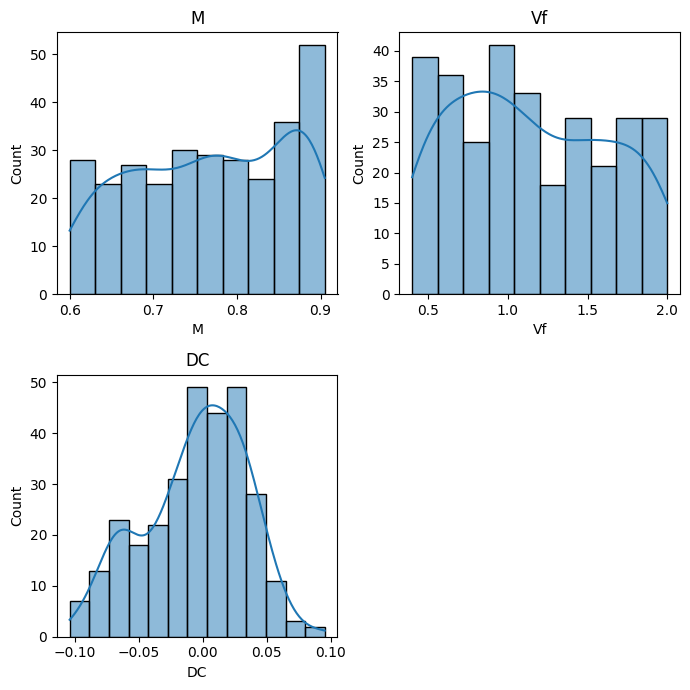

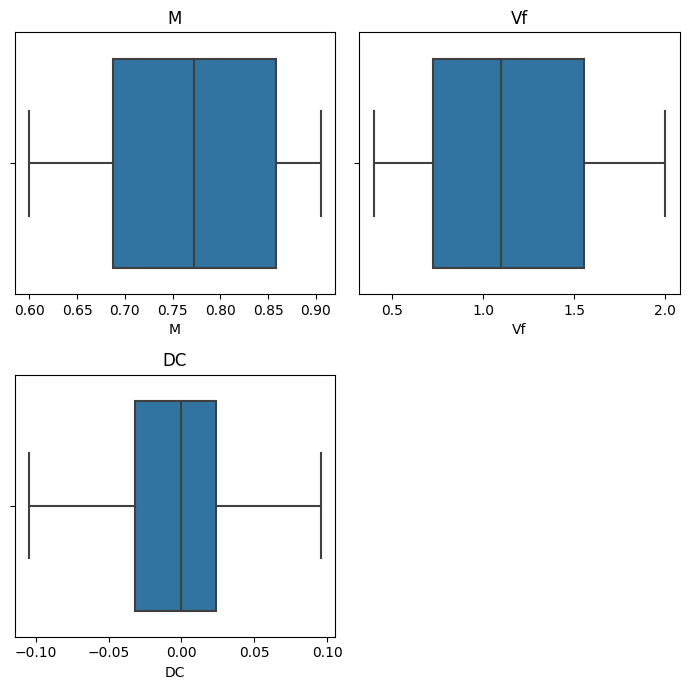

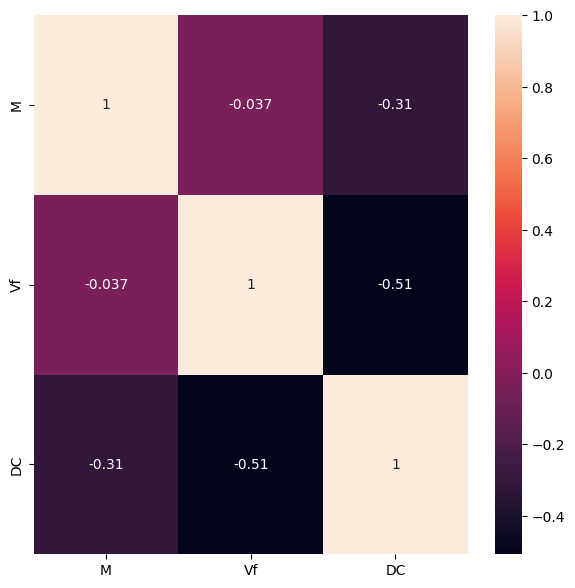

In [60]:
histplot_subplots(df)
boxplot_subplots(df)
corr_matrix(df)

### Interpretation

From the box-and-whisker plot, we can see that all columns on the dataset don't contain outlier, which may disturb our model.

From the correlation matrix of Pearson correlation constant, we can see that damping coefficient have medium correlated with flutter velocity (inversely linear), while having quite low correlation with Mach number (also inversely linear).

## Feature Engineering

In [61]:
def int_is_negative(x):
    return int(x < 0)

# Add new column F: determining occurence of flutter
df["F"] = df["DC"].apply(int_is_negative)

### Another Exploratory Data Analysis

In [62]:
df["F"].describe()

count    300.000000
mean       0.503333
std        0.500824
min        0.000000
25%        0.000000
50%        1.000000
75%        1.000000
max        1.000000
Name: F, dtype: float64

## Preprocessing

In [63]:
# Split feature and target
y = df["F"]
X = df[["M", "Vf"]]

In [64]:
# Split train-test dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model Bulding

### Logistic Regression

#### Manual

##### Concept

As opposed to Linear Regression, whose aim was to generate a model that could predict outputs whose values are continuous, we would like to create a classification model with discrete predictions, e.g. 0 or 1. Normally, the task of predicting which class a point belongs to is deemed a **classification task**. However, with Logistic Regression, we would like to *model the **probability** that a specific output $Y$ belongs to a particular class/category*. In the present scenario, our data consists of samples that belong to either one of two classes, $Y=0$ or  $Y=1$. The specific task that handles data with two classes is called a **binary classification**.

With logistic regression, we create a regression model whose predictions represent a probability. Previously with linear regression, the model took the form of $Y = \beta X$ where $Y$. The logistic regression model takes the form of a logistic/sigmoid function which restricts the values of the outputs to fall in the range of $0-L$, where $L$ is some arbitrary value reflective of the outputs $Y$, usually the maximum, i.e. if $Y \in [0, 1]$ then $L=1$, so that we can interpret is a probability. A *threshold* at $\frac{L}{2}$ is usually set to denote whether a particular sample is an instance of the *default* class if its probability is above this threshold. This is convenient since the task is to classify our samples according to their classes, represented by a discrete value, but would also provide us with some form of *uncertainty* in our predictions.

For example, let the samples $X$ whose $Y=1$ denote the *default* class $C_1$, as opposed to the class $C_0$ where $Y=0$. Given a test sample $x$, if the model predicts its probability $p(x)$ as above $1/2$ then we are *certain* that $x \in C_1$, otherwise if it is less than $1/2$ then $x \in C_0$

Furthermore, since this is a regression model, we would have to *train* the model by finding the best coefficients, $\beta$, to represent the model. Like with linear regression, these coefficients are multiplied with the samples $X$.

From here on, we can now move on to the details

Logistic regression models the probability of a default class, say for the samples $X$ whose $Y=1$. Previously, we mentioned that the model takes the form of a logistic/sigmoid function. The general formula is written as,

$$ p(X)=  \frac{L}{1+e^{-(\beta X)} } $$

However, since we would like to model to predict values between 0-1, we set $L=1$ and automatically $p(X)$ will be a fraction of 1 and positive since the denominator is restricted by the negative exponential, i.e. $e^{-9999} = 0$. This is written in the following `sigmoid` function (please execute this cell):

In [65]:
# Function to call sigmoid based on scores
def sigmoid(scores):
    return 1/(1+np.exp(-scores))

##### Model Prediction
Just before we get into the training procedure, we look as to how the model makes predictions. In the ```predict``` function, we first **concatenate** our $X$ data with a vector of ones to get an array $F$. As with linear regression, this is simply representative of the *intercept* i.e. $\beta_0$. Thus, the variable ```y_pred``` is $p(X)$ and  ``` scores ``` represents $F\beta$ to which the predictions at new test points is simply the evaluation of the ```sigmoid``` function with $F\beta$:

In [66]:
# Function to calculate scores and/or prediction given by a logistic regression model
def predict(X, beta):
    # Create F matrix
    F = np.ones((X.shape[0], X.shape[1]+1))
    F[:,1:] = X
    # Calculate prediction
    scores = F@beta
    y_pred = sigmoid(scores)
    
    return scores, y_pred

##### Training the Model
To train the logistic regression model we use the **maximum likelihood principle**. The principle is essentially to **maximize the likelihood function**. The likelihood function, is **a function that measures the goodness of fit between a model and the given (training) data**. The parameters that control the model is of course $\beta$. Thus, the likelihood is a function of $\beta$ and for the default class $C1$ is written as,

$$ L(\beta) = \prod_{x \in C1}{p(x)} \prod_{x' \in C0}{(1-p(x'))} $$

For reasons outside the scope of this course, we shall instead consider maximizing the **log likelihood function** which is mathematically equivalent but just written differently for ease of computation. For a total of $N$ samples in the data array $X$, this is written as, 

$$ \text{log}(L(\beta)) = \sum_{i=1}^{N} (y_i \beta x_i - \text{log}(1+e^{\beta x_i}))$$

This function is written in ```log_likelihood_cal ```:


In [67]:
# Function to calculate log likelihood
def log_likelihood_cal(X, y, beta):
    #Calculate scores at every value of X
    scores, _ = predict(X, beta)
    log_likelihood = np.sum(y*scores-np.log(1+np.exp(scores))) #Calculate log likelihood
    
    return log_likelihood

Recall your days of multivariable calculus, specifically the topic of **finding optima** in functions. That is, the problem of **finding stationary points** (zero first derivatives). Computationally, this is done through an iterative procedure. The specific algorithm to be used in the present work is the **Newton-Raphson algorithm**.


Since we are trying to find stationary points in the log-likelihood function then we would need the first derivative.

$$ \frac{\partial L(\beta)}{\partial \beta} = \sum_{i=1}^{N} F_i (y_i - p(x_i, \beta))$$

(Recall that $F$ is simply $F = [1^T X]$ and $p$ is the evaluation of the ```sigmoid``` function with the current $F\beta$ values.)

Furthermore, with the **Newton-Raphson algorithm** we would require the second-derivative/Hessian matrix.

$$ \frac{\partial^2 L(\beta)}{\partial \beta \partial \beta^T} = \sum_{i=1}^{N} -F_i F_i^{T}p(x_i, \beta) (1 - p(x_i, \beta))$$

Please execute the cell below to create the ```log_likelihood_der_cal``` subroutine that we will need to find the best logistic regression model:


In [68]:
# Function to call the derivative of log likelihood calculation
def log_likelihood_der_cal(X,y,beta):
    #Create F matrix
    F = np.ones((X.shape[0],X.shape[1]+1))
    F[:,1:] = X
    #Calculate scores
    scores,_ = predict(X, beta)
    #Calculate the first derivatives
    dl = np.sum(F*(y-sigmoid(scores)).reshape(-1,1),axis=0) #First derivatives

    #Calculate the second derivatives
    temp = np.ones((F.shape[1],F.shape[1],F.shape[0]))
    for i in range(X.shape[0]):
        temp[:,:,i] = np.multiply(F[i,:].reshape(-1,1)@F[i,:].reshape(-1,1).T,-1*sigmoid(scores[i])*(1-sigmoid(scores[i])))
    dl2 = np.sum(temp,axis=2) #Second derivatives
    
    return dl,dl2

The process of maximizing the log-likelihood, would go as follows:

**Initialization:**

1. Set initial $\beta_0$ to, say, all zeros. ($\beta^{old}=\beta_0$)
2. Set an initial log-likelihood to zero $(LL^{old})$, and compute another log-likelihood $(LL^{now})$ based on $\beta_0$ 
3. Set a tolerance value, say $1\times 10^{-6}$ , which shall form the stopping criteria as $ \textrm{if} \quad (|LL^{now} - LL^{old}| < 1\times 10^{-6}) \rightarrow \textrm{stop}$

**Main Procedure**

$\textrm{while} \quad |LL^{now} - LL^{old}| > 1\times 10^{-6}$
1. Compute $\beta^{now} = \beta^{old} - \Big(\frac{\partial^2 L(\beta)}{\partial \beta \partial \beta^T}\Big)^{-1}\Big(\frac{\partial L(\beta)}{\partial \beta}\Big)$
2. Set $LL^{old} = LL^{now}$
3. Recompute $LL^{now}$ based on $\beta^{now}$
3. Recompute $\frac{\partial^2 L(\beta)}{\partial \beta \partial \beta^T}$ and $\frac{\partial L(\beta)}{\partial \beta}$

The cell below contains the subroutine that we will use to to find the best logistic regression parameter:

In [69]:
# Function to create a logistic regression model on the data. The model is obtained by conducting procedure to maximize log likelihood.
def logistic_regression_train(X,y):
    # Initial values for the model coefficients. (All set to zeros)
    beta = np.zeros((X.shape[1]+1))
    
    likelihood_old = 0
    likelihood_now = log_likelihood_cal(X,y,beta) #Log likelihood value of the initial model
    [dl,dl2] = log_likelihood_der_cal(X,y,beta) #Log likelihood derivatives of the initial model 
    it = 0
    tol = 1e-20 #Tolerance value to stop iteration
    while np.abs(likelihood_now-likelihood_old) > tol:
        it = it+1
        beta = beta-np.linalg.inv(dl2)@dl #New model coefficients, based on a gradient descent optimization scheme.
        likelihood_old = np.copy(likelihood_now) #Log likelihood value of the previous model.
        likelihood_now = log_likelihood_cal(X,y,beta) #Log likelihood value of the current model.
        [dl,dl2] = log_likelihood_der_cal(X,y,beta) #Log likelihood derivatives of the current model
        print("Iteration: {}, Likelihood:{}".format(it,likelihood_now))
        
    se = np.sqrt(np.diag(np.linalg.inv(-dl2))) #Calculate standard deviation of each model coefficient 
    
    return beta,likelihood_now, se

The following cell train your logistic regression model based on the given $X$ and $y$. The procedure automatically stops when it finds the optimum parameters:

In [70]:
# To obtain a logistic regression model on your data, call logistic_regression_train
X_train_array = X_train.to_numpy()
y_train_array = y_train.to_numpy()

[beta,likelihood,beta_se] = logistic_regression_train(X_train_array, y_train_array)

# Print the coefficients
print("The coefficients of your logistic regression model are as follows:")
for i in range(0, 2):
    print('beta_{} = {:.4f}'.format(i,beta[i]))

Iteration: 1, Likelihood:-118.1566631855749
Iteration: 2, Likelihood:-114.45580911075164
Iteration: 3, Likelihood:-114.2834177601294
Iteration: 4, Likelihood:-114.28281866678262
Iteration: 5, Likelihood:-114.28281865845148
Iteration: 6, Likelihood:-114.28281865845148
The coefficients of your logistic regression model are as follows:
beta_0 = -12.1254
beta_1 = 11.5504


##### Evaluating and Interpreting

After you build your logistic regression model, now you want to assess its performance and accuracy. To that end, you would need the model parameter statistics that summarize important values. Here we create a summary for the model parameter statistics:

In [71]:
# Function to create summary matrix
from scipy import stats

def summarymat_log(beta, beta_se):
    n_var = beta.shape[0]-1
    summary = np.zeros((n_var+1,5))
    summary[:,0] = beta #Model coefficients. 
    summary[:,1] = beta_se #Standard deviation of each model coefficient. 
    summary[:,2] = np.divide(summary[:,0],summary[:,1]) #Z-statistic.
    summary[:,3] = stats.norm.sf(np.abs(summary[:,2]))*2 #Calculate p-value based on z-statistic.
    #Hypothesis test with 95% confidence interval
    for i in range(n_var+1):
        if summary[i,3]<= 0.05: #If p<=0.05, null hypothesis is denied
            summary[i,4] = 1
        else:
            summary[i,4] = 0 #If p<=0.05, null hypothesis is accepted
            
    return summary

In [72]:
# To create summary matrix of the trained model, call summarymat_log function
summary = summarymat_log(beta, beta_se)
print("Summary Matrix: ")
print(pd.DataFrame(summary,columns=['Beta','Standard Deviation', 'z-statistic', 'p-value', 'Hypothesis Test']))

Summary Matrix: 
        Beta  Standard Deviation  z-statistic       p-value  Hypothesis Test
0 -12.125372            1.810817    -6.696079  2.140867e-11              1.0
1  11.550371            2.013077     5.737669  9.598849e-09              1.0
2   2.972623            0.417002     7.128561  1.014233e-12              1.0


As with linear regression previously, we can compute the $R^{2}$ score to see how accurate our regression model is applicable on continuous outputs. However, since our outputs will ultimately be categorical, we consider a *pseudo* $R^{2}$ metric.

In [73]:
def pseudo_r2_comp(y_true,y_pred):
    pos = np.where(y_true==1) #To determine which rows with y=1
    neg = np.where(y_true==0) #To determine which rows with y=0

    # Calculate odds
    odds = pos[0].shape[0]/neg[0].shape[0]

    # Procedure to calculate pseudo TSS
    p_odds = odds/(1+odds)
    pseudo_tss = np.sum(y_true*np.log(p_odds)+(1-y_true)*np.log(1-p_odds))

    #Procedure to calculate pseudo R2
    scores = np.log(y_pred/(1-y_pred))
    log_likelihood = np.sum(y_true*scores-np.log(1+np.exp(scores))) #Calculate log likelihood
    pseudo_R2 = (pseudo_tss-likelihood)/pseudo_tss
    
    return pseudo_R2

In [74]:
# To obtain pseudo R2 error, call pseudo_R2_comp function
_, y_train_pred = predict(X_train.to_numpy(), beta)
pseudo_R2 = pseudo_r2_comp(y_train.to_numpy(), y_train_pred)
print("Pseudo R2 error: {}".format(pseudo_R2))

Pseudo R2 error: 0.3113284045927075


In [75]:
# Predict the test data
_, y_pred_lgr_manual_prob = predict(X_test.to_numpy(), beta)

Previously our ```predict``` function gave us the probabilities of an output, however, since the aim here is to classify samples we introduce the extra steps of including the *threshold* as previously mentioned.

In [76]:
def sigmoid_to_bilabel(y, margin):
    cond_list = [y < margin, y >= margin]
    choice_list = [0, 1]

    return np.select(cond_list, choice_list)

y_pred_lgr_manual = sigmoid_to_bilabel(y_pred_lgr_manual_prob, 0.5)

#### Using scikit-learn

In [77]:
from sklearn.linear_model import LogisticRegression

# Initiate the model
lgr = LogisticRegression()

# Train the model
lgr.fit(X_train, y_train)

# Predict the test data
y_pred_lgr = lgr.predict(X_test)

### K-Nearest Neighbors Classification

In [78]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

# Scale the feature
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Find the optimum n_neighbors using grid search cross validation
knn_tuning = KNeighborsClassifier()

# Create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}

# Use GridSearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn_tuning, param_grid, cv=10)

# Fit model to training data
knn_gscv.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [80]:
# Initiate the model
knn = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_["n_neighbors"])
# knn = KNeighborsClassifier(n_neighbors=1)

# Train the model
knn.fit(X_train_scaled, y_train)

# Predict the test data
y_pred_knn = knn.predict(X_test_scaled)

## Model Validation

In [81]:
from sklearn.metrics import classification_report

# Use report module from sklearn
print("Manual Logistic Regression")
print(classification_report(y_test, y_pred_lgr_manual))

print("sklearn Logistic Regression")
print(classification_report(y_test, y_pred_lgr))

print("K-Nearest Neighbors Classifier")
print(classification_report(y_test, y_pred_knn))

Manual Logistic Regression
              precision    recall  f1-score   support

           0       0.81      0.83      0.82        36
           1       0.74      0.71      0.72        24

    accuracy                           0.78        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.78      0.78      0.78        60

sklearn Logistic Regression
              precision    recall  f1-score   support

           0       0.77      0.75      0.76        36
           1       0.64      0.67      0.65        24

    accuracy                           0.72        60
   macro avg       0.71      0.71      0.71        60
weighted avg       0.72      0.72      0.72        60

K-Nearest Neighbors Classifier
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        36
           1       0.86      1.00      0.92        24

    accuracy                           0.93        60
   macro avg       0.93      0.94      0.9

Text(0.5, 1.0, 'K-Nearest Neighbors Classification Model')

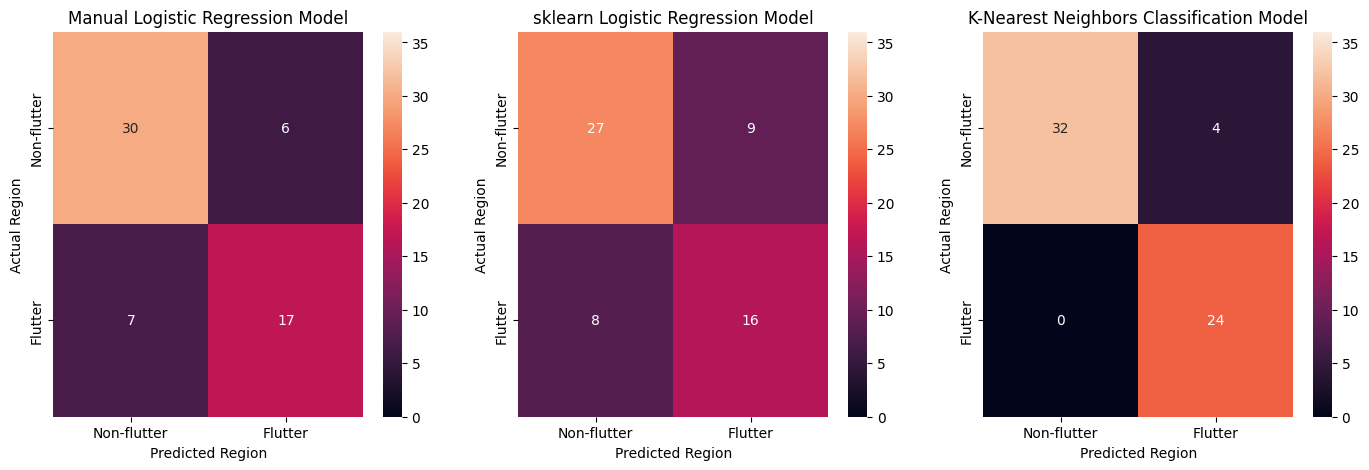

In [82]:
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
cm_lgr_m = confusion_matrix(y_test, y_pred_lgr_manual)
cm_lgr = confusion_matrix(y_test, y_pred_lgr)
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Initialize figure
fig, ax = plt.subplots(1, 3, figsize=(17, 5))

# Draw the confusion matrix
sns.heatmap(cm_lgr_m, annot=True, fmt='d', ax=ax[0], vmin=0, vmax=36)
sns.heatmap(cm_lgr, annot=True, fmt='d', ax=ax[1], vmin=0, vmax=36)
sns.heatmap(cm_knn, annot=True, fmt='d', ax=ax[2], vmin=0, vmax=36)

# Set x-axis label and ticks 
ax[0].set_xlabel("Predicted Region")
ax[0].xaxis.set_ticklabels(['Non-flutter', 'Flutter'])
ax[1].set_xlabel("Predicted Region")
ax[1].xaxis.set_ticklabels(['Non-flutter', 'Flutter'])
ax[2].set_xlabel("Predicted Region")
ax[2].xaxis.set_ticklabels(['Non-flutter', 'Flutter'])

# Set y-axis label and ticks
ax[0].set_ylabel("Actual Region")
ax[0].yaxis.set_ticklabels(['Non-flutter', 'Flutter'])
ax[1].set_ylabel("Actual Region")
ax[1].yaxis.set_ticklabels(['Non-flutter', 'Flutter'])
ax[2].set_ylabel("Actual Region")
ax[2].yaxis.set_ticklabels(['Non-flutter', 'Flutter'])

# Set title
ax[0].set_title("Manual Logistic Regression Model")
ax[1].set_title("sklearn Logistic Regression Model")
ax[2].set_title("K-Nearest Neighbors Classification Model")

### Interpretation

From `classification_report` from sklearn, we may see the precision, recall, and f1-score of our model when applying it to the test data. `0` stands for non-flutter region, and vice versa for `1`.

For the manual linear logistic model, here are some information that we can interpret:
* From all the flutter region in the test data, the model can only predict 74% of it correctly (0.74 of precision).
* From all the predicted flutter region, only 71% of it are correctly predicted (0.71 of recall).
* From all the non-flutter region in the test data, the model can only predict 81% of it correctly (0.81 of precision).
* From all the predicted non-flutter region, only 83% of it are correctly predicted (0.83 of recall).
* Overall, the model has 78% of accuracy for all its predicted value.

For the sklearn's linear logistic model, here are some information that we can interpret:
* From all the flutter region in the test data, the model can only predict 64% of it correctly (0.64 of precision).
* From all the predicted flutter region, only 67% of it are correctly predicted (0.67 of recall).
* From all the non-flutter region in the test data, the model can only predict 77% of it correctly (0.77 of precision).
* From all the predicted non-flutter region, only 75% of it are correctly predicted (0.75 of recall).
* Overall, the model has 72% of accuracy for all its predicted value.

For the KNN classifier model, here are some information that we can interpret:
* From all the flutter region in the test data, the model can only predict 86% of it correctly (0.86 of precision).
* From all the predicted flutter region, 100% of it are correctly predicted (1.00 of recall).
* From all the non-flutter region in the test data, the model can predict 100% of it correctly (1.00 of precision).
* From all the predicted non-flutter region, only 89% of it are correctly predicted (0.89 of recall).
* Overall, the model has 93% of accuracy for all its predicted value.

Here, prediction of flutter region is important, as it's crucial for aircraft wing designing. Therefore, the occurence of false negative in our model is very undesirable. Thus F1-score is used to determine which model is better. For macro averaged calculation, we can see that our KNN classifier model is better than both of our logistic regression model. This can be more visualized below.

## Plotting Result

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


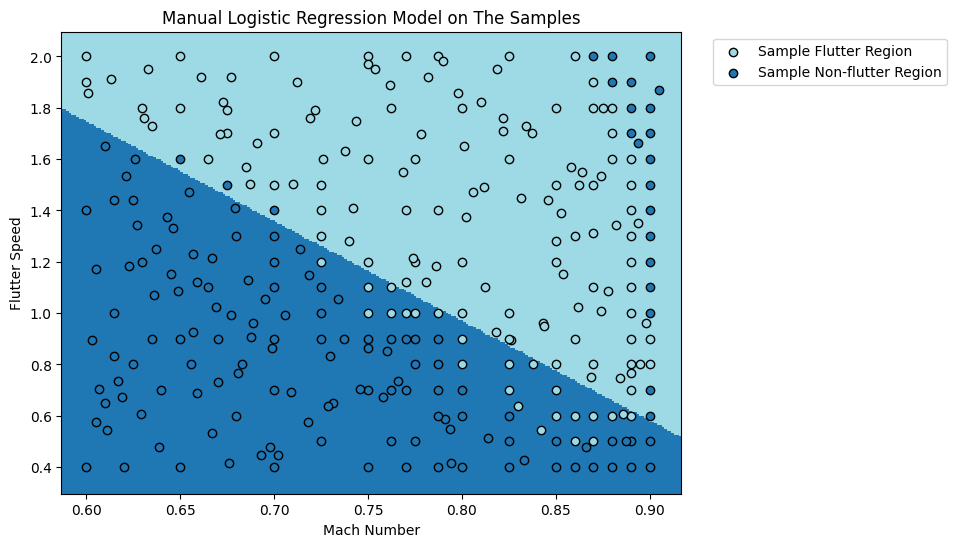

In [83]:
# Create the location of X to visualize
X1_min, X1_max = X['M'].min()-0.0125, X['M'].max()+0.0125
X2_min, X2_max = X['Vf'].min()-0.1, X['Vf'].max()+0.1

h1 = (X1_max-X1_min)/250
h2 = (X2_max-X2_min)/250

# Calculate prediction at each prediction location
XX1, XX2 = np.meshgrid(np.arange(X1_min, X1_max, h1), np.arange(X2_min, X2_max, h2))
X_norm = np.c_[XX1.ravel(), XX2.ravel()]

# Predict for every location
_,y_pred_mesh_prob = predict(np.c_[XX1.ravel(), XX2.ravel()], beta)
y_pred_mesh = sigmoid_to_bilabel(y_pred_mesh_prob, 0.5)
y_pred_mesh = y_pred_mesh.reshape(XX1.shape)

# Formatting the plot figure: color and size
plt.figure(1, figsize=(8, 6))
cmap = plt.cm.tab20
plt.set_cmap(cmap)
plt.pcolormesh(XX1, XX2, y_pred_mesh)

# Plotting the result
flut = df.loc[df["F"] == 1]
no_flut = df.loc[df["F"] == 0]
plt.scatter(flut["M"],flut["Vf"],label='Sample Flutter Region',c=cmap(20),edgecolors='k')
plt.scatter(no_flut["M"],no_flut["Vf"],label='Sample Non-flutter Region',c=cmap(0),edgecolors='k')

# Miscellaneous information
plt.xlabel('Mach Number')
plt.ylabel('Flutter Speed')

plt.title('Manual Logistic Regression Model on The Samples')

plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


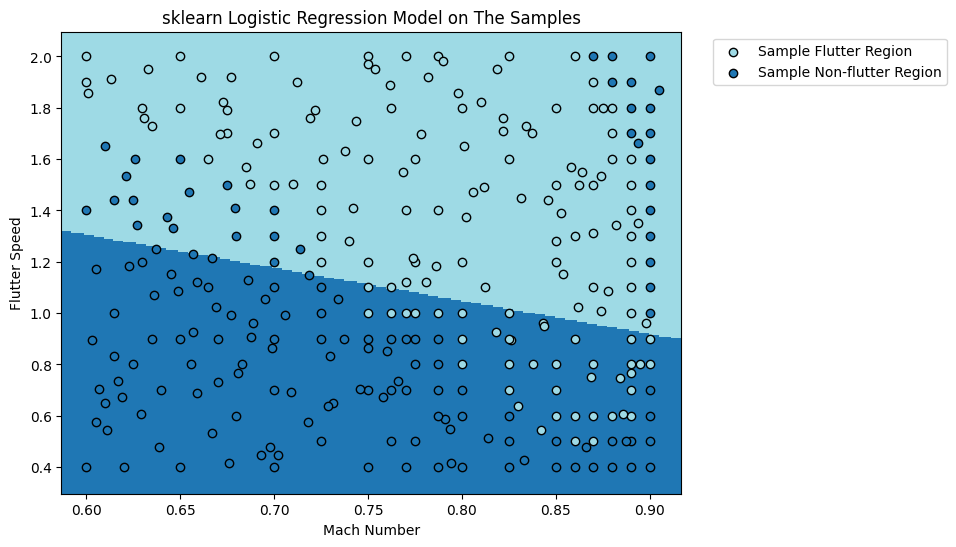

In [84]:
# Create the location of X to visualize
X1_min, X1_max = X['M'].min()-0.0125, X['M'].max()+0.0125
X2_min, X2_max = X['Vf'].min()-0.1, X['Vf'].max()+0.1

h1 = (X1_max-X1_min)/250
h2 = (X2_max-X2_min)/250

# Calculate prediction at each prediction location
XX1, XX2 = np.meshgrid(np.arange(X1_min, X1_max, h1), np.arange(X2_min, X2_max, h2))
X_norm = np.c_[XX1.ravel(), XX2.ravel()]

# Predict for every location
y_pred_mesh = lgr.predict(X_norm)
y_pred_mesh = y_pred_mesh.reshape(XX1.shape)

# Formatting the plot figure: color and size
plt.figure(1, figsize=(8, 6))
cmap = plt.cm.tab20
plt.set_cmap(cmap)
plt.pcolormesh(XX1, XX2, y_pred_mesh)

# Plotting the result
flut = df.loc[df["F"] == 1]
no_flut = df.loc[df["F"] == 0]
plt.scatter(flut["M"],flut["Vf"],label='Sample Flutter Region',c=cmap(20),edgecolors='k')
plt.scatter(no_flut["M"],no_flut["Vf"],label='Sample Non-flutter Region',c=cmap(0),edgecolors='k')

# Miscellaneous information
plt.xlabel('Mach Number')
plt.ylabel('Flutter Speed')

plt.title('sklearn Logistic Regression Model on The Samples')

plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

/shared-libs/python3.10/py/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


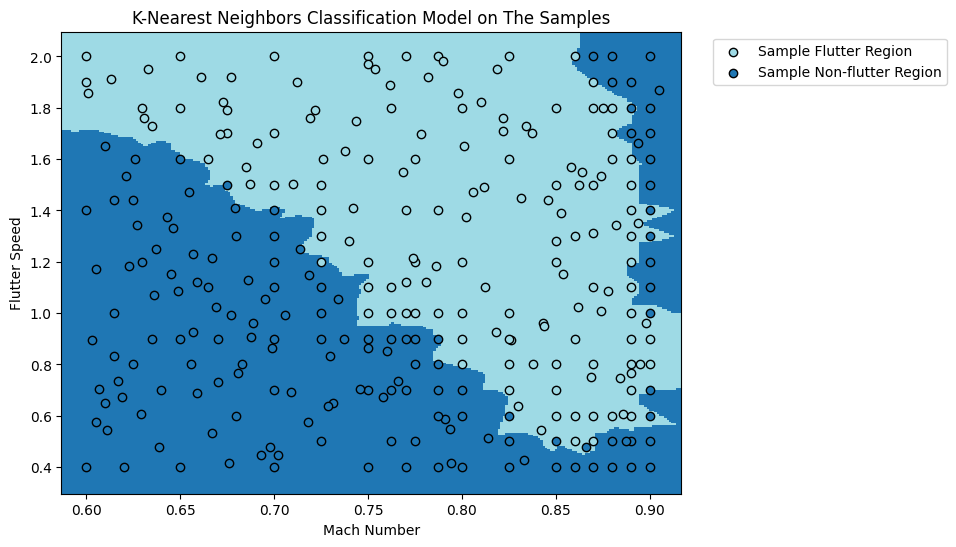

In [85]:
# Create the location of X to visualize
X1_min, X1_max = X['M'].min()-0.0125, X['M'].max()+0.0125
X2_min, X2_max = X['Vf'].min()-0.1, X['Vf'].max()+0.1

h1 = (X1_max-X1_min)/250
h2 = (X2_max-X2_min)/250

# Calculate prediction at each prediction location
XX1, XX2 = np.meshgrid(np.arange(X1_min, X1_max, h1), np.arange(X2_min, X2_max, h2))
X_norm = np.c_[XX1.ravel(), XX2.ravel()]

# Predict for every location
scaler_X = MinMaxScaler()
scaler_X.fit(X)
X_norm_scaled = scaler_X.transform(X_norm)
y_pred_mesh = knn.predict(X_norm_scaled)
y_pred_mesh = y_pred_mesh.reshape(XX1.shape)

# Formatting the plot figure: color and size
plt.figure(1, figsize=(8, 6))
cmap = plt.cm.tab20
plt.set_cmap(cmap)
plt.pcolormesh(XX1, XX2, y_pred_mesh)

# Plotting the result
flut = df.loc[df["F"] == 1]
no_flut = df.loc[df["F"] == 0]
plt.scatter(flut["M"],flut["Vf"],label='Sample Flutter Region',c=cmap(20),edgecolors='k')
plt.scatter(no_flut["M"],no_flut["Vf"],label='Sample Non-flutter Region',c=cmap(0),edgecolors='k')

# Miscellaneous information
plt.xlabel('Mach Number')
plt.ylabel('Flutter Speed')

plt.title('K-Nearest Neighbors Classification Model on The Samples')

plt.legend(bbox_to_anchor=(1.04, 1))

plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=b6c15a45-8d06-4acb-ae55-e8dab1b7dec4' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>